#                                          Language recognizer

In [2]:
import os as os
import time
import cv2
import random
#import soundfile as sf
#import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import pickle

#from python_speech_features import mfcc

from keras.layers import Flatten
from keras.models import load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization


from scipy import signal as sg
from scipy.signal import butter, lfilter


from sklearn.metrics import confusion_matrix
import seaborn as sns

from random import shuffle

import pandas as pd

Using TensorFlow backend.


# Preparación del dataset 

El dataset (obtenido de kaggle: https://www.kaggle.com/toponowicz/spoken-language-identification) utilizado se compone de audios de 10 segundos de duración en tres idiomas distintos: alemán, inglés y español. Hay tanto audios limpios de ruido, y otros con Data Augmentation: con ruido ambiente de fondo, otros con "pitch" y otros con "speed" es decir audios algo acelerados. 
Esto es para que el clasificador sea capaz de evaluar cualquier tipo de muestra sin importar el contexto de su grabación y que sea lo más genérico posible en cuanto al tipo de usuario. Además, se compone de audios tanto de hombres como de mujeres, lo cual es importante a considerar a la hora de extraer los MFCC de cada muestra.
El trabajo es escalable a más idiomas pero eso implica la utilización de un dataset mayor y más tiempo de procesamiento.

In [0]:
# Importo el dataset de train

def dataset(all_root='dataset2/train/train', tipo='train'):

        de_signals = list()
        es_signals = list()
        en_signals = list()

        de_languages = list()
        es_languages = list()
        en_languages = list()

        de_files = list()
        es_files = list()
        en_files = list()

        i=1

        for subdir, dirs, files in os.walk(all_root):       
            for file in files:
                if i%500==0:
                    print(i)
                i=i+1
                filepath = subdir + os.sep + file
                if filepath.endswith(".flac"):
                    data, fs = sf.read(filepath, dtype='float32')
                    #german=0, english=1, spanish=2
                    if file.startswith('de'):
                        de_languages.append(0)
                        de_files.append(file)
                        de_signals.append(data)
                    elif file.startswith('en'):
                        en_languages.append(1)
                        en_files.append(file)
                        en_signals.append(data)
                    elif file.startswith('es'):
                        es_languages.append(2)
                        es_files.append(file)
                        es_signals.append(data)
                        
        if tipo=='train':
            return de_languages, de_signals, en_languages, en_signals, es_languages, es_signals
            
        elif tipo=='test':
            languages = de_languages + en_languages + es_languages
            signals = de_signals + en_signals + es_signals
            return languages, signals

In [0]:
de_languages, de_signals, en_languages, en_signals, es_languages, es_signals  = dataset('dataset2/train/train', tipo='train')
print(len(de_languages), len(de_signals), len(en_languages), len(en_signals), len(es_languages), len(es_signals))
#test_languages, test_files, test_signals = dataset('dataset2/test', tipo='test')

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
4023 4023 4566 4566 5181 5181


## Shuffle y preparación del training set/ validation set

En primer lugar, dado que el dataset utilizado es de aproximadamente 5GBy, se decidió por una cuestión de procesamiento y memoria RAM utilizar un porcentaje del mismo. Además, como se obtuvieron la muestras por separado para cada idioma, se realiza un **shuffle** de manera de que en el dataset se encuentren intercalados audios de hombre, mujer, con o sin ruido, etc. Esto hará que se obtenga un mejor accuracy a la hora de entrenar, evitando que la red tienda hacia un camino específico.
Luego de mezclar y haber decidido el porcentaje a utilizar para cada dataset, se lo armará concatenando en proporciones similares de cada idioma.

In [0]:
print(time.ctime())
factor=0.5 #Limite del dataset de train
factor2=0.6 #Limite del dataset de validación


shuffle(de_signals)
shuffle(en_signals)
shuffle(es_signals)

train_signals = list() #Datos de los audios de entrenamiento
train_languages = list() #Etiquetas propias de cada idioma
test_signals = list()
test_languages = list()

train_signals = de_signals[0:int(factor*len(de_signals))] + en_signals[0:int(factor*len(en_signals))] + es_signals[0:int(factor*len(es_signals))]
train_languages = de_languages[0:int(factor*len(de_signals))] + en_languages[0:int(factor*len(en_signals))] + es_languages[0:int(factor*len(es_signals))]

test_signals = de_signals[int(factor*len(de_signals)):int(factor2*len(de_signals))] + en_signals[int(factor*len(en_signals)):int(factor2*len(en_signals))] + es_signals[int(factor*len(es_signals)):int(factor2*len(es_signals))]
test_languages = de_languages[int(factor*len(de_signals)):int(factor2*len(de_signals))] + en_languages[int(factor*len(en_signals)):int(factor2*len(en_signals))] + es_languages[int(factor*len(es_signals)):int(factor2*len(es_signals))]


print(time.ctime())
#print('Train: \n{} \n\tSize: {}'.format( train_languages, len(train_languages)) )
#print('Train Signals: Size: {}'.format(len(train_signals)))
#print('\n\n\nTest: \n{}\n\tSize: {}'.format(test_languages,len(test_languages)) )

print(len(test_signals), len(test_languages))
print(len(train_signals), len(train_languages))

Fri Feb 15 17:55:41 2019
Fri Feb 15 17:55:41 2019
1376 1376
6884 6884


In [0]:
with open('train_languages', 'wb') as f:
    pickle.dump(train_languages, f)
with open('test_languages', 'wb') as f:
    pickle.dump(test_languages, f)

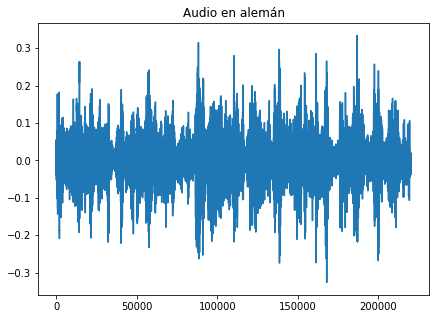

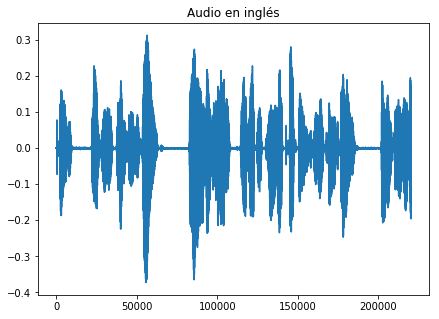

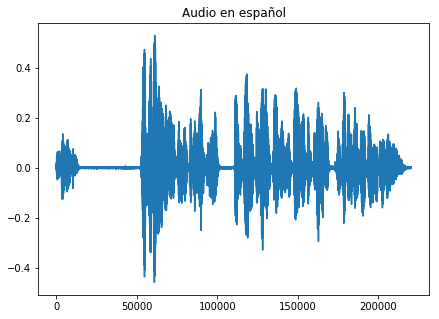

In [0]:
ejemplo_de = train_signals[0]
ejemplo_en = train_signals[int(factor*len(de_signals))+1]
ejemplo_es = train_signals[len(train_signals)-1]

plt.figure(1, figsize=(7,5))
plt.title('Audio en alemán')
plt.plot(ejemplo_de)

plt.figure(2, figsize=(7,5))
plt.title('Audio en inglés')
plt.plot(ejemplo_en)

plt.figure(3, figsize=(7,5))
plt.title('Audio en español')
plt.plot(ejemplo_es)

## Pre-Procesamiento de las muestras

Extraccion de MFCC de todas las muestras.

In [0]:
def preprocess(signal_list, language_list, fs=22050, w_secs=20e-3, n_languages=3, n_past=6):
    
    mfcc_list = list()
    label_list = list()
    live=0
    
    for i in range(len(signal_list)):
       
        live = live+1
        if live%500 ==0:
            print (live)

        mfccs = mfcc(signal_list[i], fs, winlen=w_secs, winstep=w_secs/2, appendEnergy=True, winfunc=np.hanning, nfft=1024)
        mfcc_list.append(mfccs)
        label_list.append(np.ones(len(mfccs))*language_list[i])
        
    mfcc_array = np.array(mfcc_list)
    features_array = np.reshape(mfcc_array, (mfcc_array.shape[0]*mfcc_array.shape[1],mfcc_array.shape[2]))

    for p in range(1,n_past+1):
        past_array = np.zeros_like(mfcc_array)
        for i in range(mfcc_array.shape[0]):
            for j in range(p,mfcc_array.shape[1]):
                past_array[i][j] = mfcc_array[i][j-p]
        past_array = np.reshape(past_array, (past_array.shape[0]*past_array.shape[1],past_array.shape[2]))
        features_array = np.append(features_array, past_array, axis=1)
    
    label_array = np.array(label_list)
    label_array = np.reshape(label_array, (label_array.shape[0]*label_array.shape[1],1))
    label_onehot = np_utils.to_categorical(label_array, num_classes=n_languages)
    
    return features_array, label_onehot

### Filtrado de la señal

En caso de ser conveniente se filtrára la señal con un pasabajos con la aproximación Butterworth, para que sea más fácil de procesar, eliminando los picos propios del ruido de alta frecuencia. El orden del filtro y sus parámetros se ajustan a prueba y error, basándose en http://www.stackoverflow.com, de manera de obtener mejores resultados.
Para ajustar los parámetros del filtro se observaron los gráficos siguientes. La idea principal del filtrado es facilitarle a la red la distinción entre cada idioma.

**Fs**: Frecuencia de sampleo normalizada

**Cut**: Frecuencia de corte pasa bajos

**Order**: Orden del filtro ButterWorth

**Data**: Señales a filtrar

In [0]:
def butter_lowpass(cut, fs, order=5):
    nyq = 0.5 * fs
    cutoff = cut / nyq
    b, a = butter(order, cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cut, fs, order=5):
    b, a = butter_lowpass(cut, fs, order=order)
    output = lfilter(b, a, data)
    return output

220500


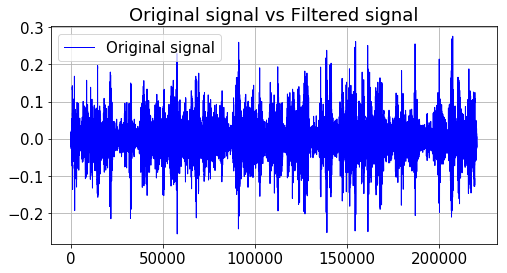

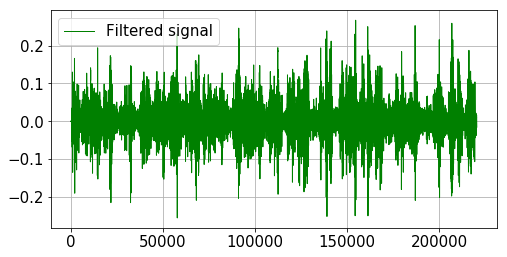

In [0]:
fs = 22050

for subdir, dirs, files in os.walk('dataset2/train/train'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith("de_f_5d2e7f30d69f2d1d86fd05f3bbe120c2.fragment1.noise4.flac"):
            test, fs = sf.read(filepath, dtype='float32')

test_filtered= butter_lowpass_filter(test, 800, fs, order=10)

plt.figure(1, figsize=(8,4))
plt.grid()
font = {'size'   : 15}
plt.rc('font', **font)
plt.title('Original signal vs Filtered signal')
plt.plot(test, linewidth=1, color='b', label='Original signal')
plt.legend(loc='best')
plt.figure(2, figsize=(8,4))
plt.grid()
plt.plot(test_filtered, linewidth=1, color='g', label='Filtered signal')
plt.legend(loc='best')
print(len(test))

Al comparar los resultados de obtener features de las señales originadas y las filtradas no se observaron ventajas, por lo que se utilizarán las muestras sin filtrar.

## Normalizacion de los datos de entrenamiento

Puede ser conveniente ingresar a la red con valores normalizados, por lo que se crea la siguiente función:

In [0]:
def Normalize(data):
    mean_data = np.mean(data)
    std_data = np.std(data)
    norm_data = (data-mean_data)/std_data
    return norm_data

#train_features_normalized = Normalize(train_features)
#test_features_normalized = Normalize(test_features)

# Extraccion de features (MFCC) de todo el dataset

Los Mel Frequency Cepstral Coefficients (Coeﬁcientes Cepstrales en las Frecuencias de Mel) o MFCCs son coeﬁcientes para la representación del habla basados en la percepción auditiva humana. Estos surgen de la necesidad, en el área del reconocimiento de audio automático, de extraer características de las componentes de una señal de audio que sean adecuadas para la identificación de contenido relevante, así como obviar todas aquellas que posean información poco valiosa como el ruido de fondo, emociones, volumen, tono, etc. y que no aportan nada al proceso de reconocimiento, al contrario lo empobrecen.

MFCCs se calculan comúnmente de la siguiente forma:

**1)** Separar la señal en pequeños tramos.

**2)** A cada tramo aplicarle la Transformada de Fourier discreta y obtener la potencia espectral de la señal (o la energía).

**3)** Aplicar el banco de filtros correspondientes al espectro obtenido en el paso anterior y sumar las energías en cada uno de ellos.

**4)** Tomar el logaritmo de todas las energías de cada frecuencia mel.

**5)** Aplicarle la transformada de coseno discreta a estos logaritmos.

A continuación se definen las variables a utilizar, de las cuales dependerán los features extraídos:
- fs: Frecuencia de muestreo de cada señal en hz
- w_secs: Duración de cada ventana en ms. Esto se elige conociendo el tamaño total de cada muestra (en este caso 10 segundos)
- step_size: Es el paso entre ventanas consecutivas. De esto surgirá luego el overlap en cada muestra. Se elige de modo que haya un 50% de overlap entre ventanas.
- window: Es el tipo de ventana a utilizar a la hora de realizar la fft. Es de la siguiente forma:
<img src="Hanning.jpg", width=350, height=700>
- n_past: es el número de pasadas por frame. Se ha probado desde 1 en adelante, comprobando que a mayor cantidad de frames se obtienen mejores resultados, hasta llegar a 7. A mayor cantidad de pasadas será mayor el tiempo de procesamiento necesario y mayor el tamaño de los features obtenidos, por lo que tardará más el entrenamiento de la red. Por esto el valor óptimo es el menor de los cuales provean la mejor performance.


In [0]:
fs = 22050 # Frecuencia de muestreo en Hz
w_secs = 30e-3 # Duración de la ventana en ms
w_dur = int(fs*w_secs) # Duración de la ventana en muestras
step_size = w_dur//2 # Step-size (overlap = w_dur - step_size)
window = np.hanning(w_dur) # Ventana
n_past = 7  # Ventanas pasadas por frame

### Obtención de features para el train test

Se guardan los MFCC de entrenamiento y los labels en forma de "one_hot encoding" dejándolo listo para la red.

In [0]:
print(time.ctime())
train_features, train_labels = preprocess(train_signals, train_languages, w_secs=w_secs, n_past=n_past)
print(len(train_features), len(train_labels))
print(time.ctime())

Wed Feb 13 08:58:02 2019
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
4584744 4584744
Wed Feb 13 10:05:23 2019


### Obtención de features para el validation set

In [0]:
print(time.ctime())
test_features, test_labels = preprocess(test_signals, test_languages, w_secs=w_secs, n_past=n_past)
print(len(test_features), len(test_labels))
print(time.ctime())

Wed Feb 13 10:05:25 2019
500
1000
916416 916416
Wed Feb 13 10:09:03 2019


### Comparación de los features para cada idioma

Alemán: [1. 0. 0.], Inglés [0. 1. 0.], Español [0. 0. 1.]



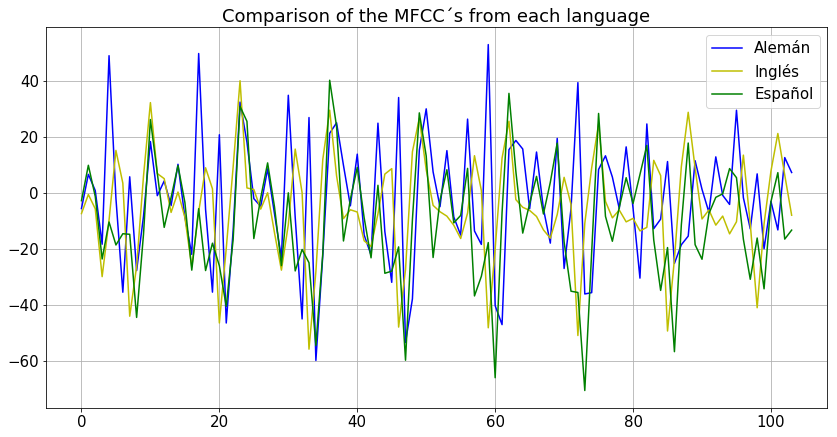

In [0]:
MFCC_de = train_features[400]
MFCC_en = train_features[len(train_labels)//2+500]
MFCC_es = train_features[len(train_labels)-500]

plt.figure(1, figsize=(14,7))
plt.grid()
plt.title('Comparison of the MFCC´s from each language')
plt.plot(MFCC_de, linewidth=1.5, color='b', label='Alemán')
plt.legend(loc='best')

plt.plot(MFCC_en, linewidth=1.5, color='y', label='Inglés')
plt.legend(loc='best')

plt.plot(MFCC_es, linewidth=1.5, color='g', label='Español')
plt.legend(loc='best')

print('Alemán: {}, Inglés {}, Español {}\n'.format(train_labels[400],  train_labels[len(train_labels)//2+500], train_labels[len(train_labels)-500]))

## Justificación de los parámetros elegidos

A la hora de obtener los MFCC, el tamaño de cada ventana en tiempo (30mS) fue elegido arbitrariamente de manera de que resulte un número considerable de ventanas por cada muestra (duran 10 segundos). El overlap de ventanas se eligió del 50% porque es el valor recomendado y normalmente utilizado.
Ahora bien, la cantidad de pasadas por frame es una variable importante ya que de su valor dependerá considerablemente el rendimiento que tenga el proyecto, y está directamente relacionada con el tamaño de los datos a procesar, por lo que existe una relación de compromiso entre tamaño de datos y accuracy. Por esto, para elegir un valor acorde se seleccionó un dataset pequeño y aleatorio con muestras del train set (de manera de que no se tarde mucho en entrenar) y se obtuvieron los MFCC de este dataset con valores de N_past desde 1 hasta 9. Luego con estos MFCC se entrenó una MLP durante 10 epochs y se observó el rendimiento hasta este momento para cada caso:

In [0]:
with open('history_1', 'rb') as f:
    history = pickle.load(f)
with open('history_2', 'rb') as f:
    history_2 = pickle.load(f)
with open('history_3', 'rb') as f:
    history_3 = pickle.load(f)   
with open('history_4', 'rb') as f:
    history_4 = pickle.load(f)
with open('history_5', 'rb') as f:
    history_5 = pickle.load(f)
with open('history_6', 'rb') as f:
    history_6 = pickle.load(f)
with open('history_7', 'rb') as f:
    history_7 = pickle.load(f)
with open('history_8', 'rb') as f:
    history_8 = pickle.load(f)
with open('history_9', 'rb') as f:
    history_9 = pickle.load(f)

In [0]:
def history_plot (tag='acc', xlabel='epoch', ylabel='acc', title='training accuracy'):
        plt.figure(1, figsize=(14,6))
        plt.grid()
        epoch = [x for x in range (10)]
        plt.plot(history.history[tag])
        plt.plot(history_2.history[tag])
        plt.plot(history_3.history[tag])
        plt.plot(history_4.history[tag])
        plt.plot(history_5.history[tag])
        plt.plot(history_6.history[tag])
        plt.plot(history_7.history[tag], linewidth=6)
        plt.plot(history_8.history[tag])
        plt.plot(epoch, history_9.history[tag])

        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(['1 ventana', '2 ventanas', '3 ventanas', '4 ventanas', '5 ventanas', '6 ventanas', '7 ventanas', '8 ventanas', '9 ventanas' ], loc='best')
        plt.show()
        # summarize history for loss

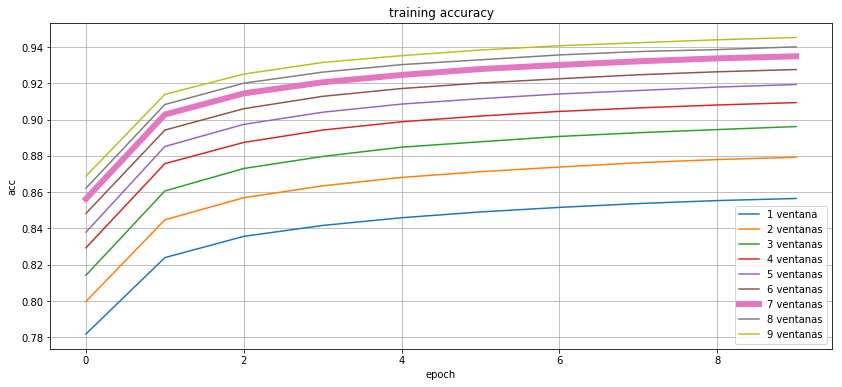

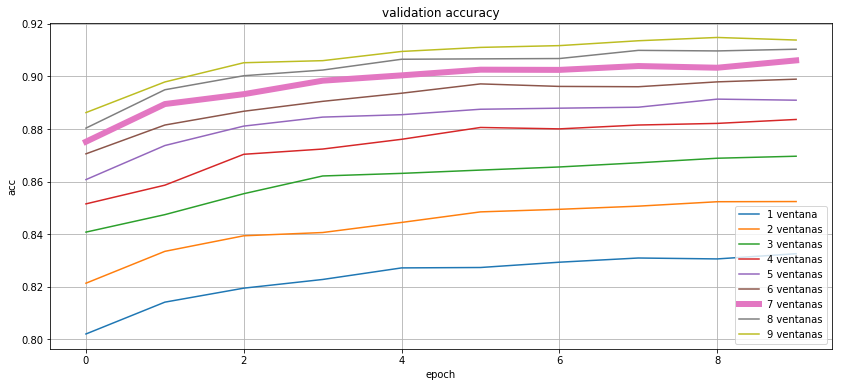

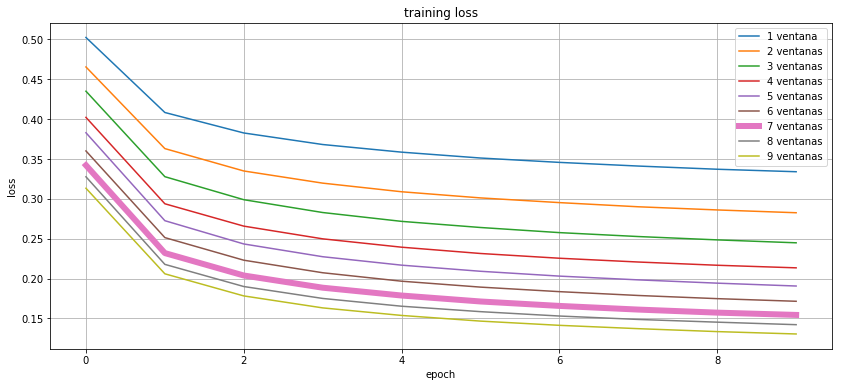

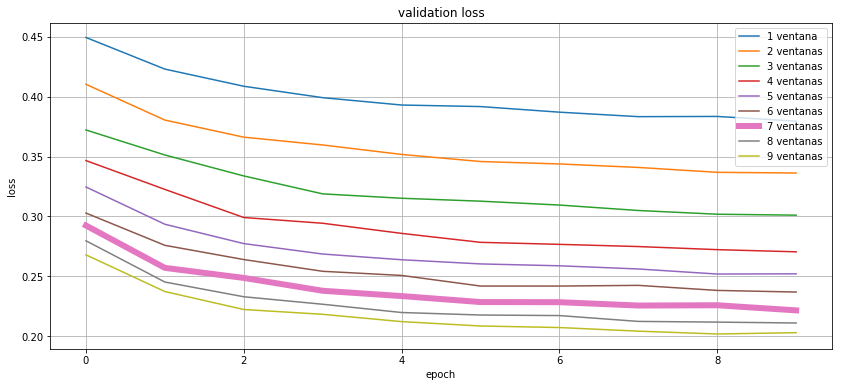

In [0]:
history_plot (tag='acc', xlabel='epoch', ylabel='acc', title='training accuracy' )
history_plot(tag='val_acc', xlabel='epoch', ylabel='acc', title='validation accuracy')
history_plot(tag='loss', xlabel='epoch', ylabel='loss', title='training loss')
history_plot(tag='val_loss', xlabel='epoch', ylabel='loss', title='validation loss')

Dado que a la hora de implementar la red realmente el tamaño del dataset es notablemente grande (aproximadamente 4GB), y que la performance obtenida a medida que aumentan las epochs no es considerable entre 6 y 9 ventanas por frame, se toma n_past=7.
Es por esto que se obtienen todos los MFCC del trainset y test set completo con estos valores.

### Guardado de los features obtenidos

In [0]:
print(type(test_features))

with open('train_features', 'wb') as f:
    pickle.dump(train_features, f)
with open('train_labels', 'wb') as f:
    pickle.dump(train_labels, f)

with open('test_features', 'wb') as f:
    pickle.dump(test_features, f)    
with open('test_labels', 'wb') as f:
    pickle.dump(test_labels, f)

In [0]:
with open('train_features', 'rb') as f:
    train_features = pickle.load(f)

with open('train_labels', 'rb') as f:
    train_labels = pickle.load(f)

with open('test_features', 'rb') as f:
    test_features = pickle.load(f)
    
with open('test_labels', 'rb') as f:
    test_labels = pickle.load(f)

FileNotFoundError: ignored

In [0]:
print(len(train_features), len(train_labels), len(test_features), len(test_labels))

4584744 4584744 916416 916416


# Red neuronal a utilizar

## MLP: Multilayer Perceptron

Una vez obtenidos los datos de entrenamiento, se elije una primera estructura de red. Como un comienzo se elige una MLP de 4 capas (dos hidden layers). 

### Regularización
Para evitar el overfitting se restringen los valores de los pesos de la segunda capa oculta, mediante L2. L2 tiene la ventaja frente a L1 que por su fórmula derivable, permite ser aplicada con métodos de minimización como Gradient Descent.
Además *L2* conocida como "Ridge regression" logra que el MSE no aumente al haber overfitting, ya que limita los pesos indistintamente para cada parámetro. Finalmente era indistinto si se regularizaba o no, por lo que no se aplicó L2.

### Dropout
El dropout consiste en omitir "aleatoriamente" ciertas neuronas. Se genera redundancia y también ayuda a evitar el overfitting de la red. Elimina conexiones entre las neuronas, de manera que se elige qué porcentaje de las neuronas se entrenará en cada iteración.

### Batch Normalization
Permite user learning rates mucho mayores, manteniendo la media de la activación cerca a 0 y el desvio cercano a 1. Además funciona como regularizador, en algunos casos hace innecesario el uso de Dropout. Sirve para acortar los tiempos de entrenamiento.


# MODELO 1

In [0]:
n_features = 13*(n_past+1) #104. Depende de los features (MFCC) que quieran usarse (13) y de las ventanas por frame (7)
n_languages = 3
# create model

model1 = Sequential()
model1.add(Dense(300, input_shape=(n_features,), activation='relu', init='uniform'))
model1.add(BatchNormalization())
model1.add(Dense(400, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(300, activation='relu'))
model1.add(Dense(n_languages, activation='softmax'))

#keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

epochs = 10
lrate = 0.02
decay = lrate/epochs
sgd = optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = optimizers.adam
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model1.summary())

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, input_shape=(104,), activation="relu", kernel_initializer="uniform")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               31500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 400)               120400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 400)               1600      
_________________________________________________________________
dense_5 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 903       
Total params: 275,903
Trainable params: 274,503
Non-trainable params: 1,400
_________________________________________________________________


In [0]:
checkpoint = ModelCheckpoint('Model_Arranco1.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

batch_size = 512

#validation_data=(test_features_normalized, test_labels)
print(time.ctime())

# Fit the model
model1.fit(train_features, train_labels, epochs=10, batch_size=batch_size, shuffle=True, validation_data=(test_features, test_labels), callbacks=callbacks_list)

print(time.ctime())

Fri Feb 15 13:10:28 2019
Train on 4584744 samples, validate on 916416 samples
Epoch 1/10
4584744/4584744 [==============================] - 260s 57us/step - loss: 0.6933 - acc: 0.6859 - val_loss: 0.6559 - val_acc: 0.7047

Epoch 00001: val_acc improved from -inf to 0.70471, saving model to Model_Arranco1.h5
Epoch 2/10
4584744/4584744 [==============================] - 255s 56us/step - loss: 0.6159 - acc: 0.7260 - val_loss: 0.6314 - val_acc: 0.7170

Epoch 00002: val_acc improved from 0.70471 to 0.71704, saving model to Model_Arranco1.h5
Epoch 3/10
4584744/4584744 [==============================] - 256s 56us/step - loss: 0.5942 - acc: 0.7367 - val_loss: 0.6192 - val_acc: 0.7231

Epoch 00003: val_acc improved from 0.71704 to 0.72307, saving model to Model_Arranco1.h5
Epoch 4/10
4584744/4584744 [==============================] - 254s 55us/step - loss: 0.5819 - acc: 0.7426 - val_loss: 0.6109 - val_acc: 0.7271

Epoch 00004: val_acc improved from 0.72307 to 0.72713, saving model to Model_Arran

# MODELO 2

Dado que el accuracy obtenido tanto para el training set como para el validation set son similares, y para cada época aumentan ambos, esto quiere decir que la red tiene resto para ser entrenado estando todavía sin presentar overfitting. Por esto, el siguiente modelo seguirá sin utilizar Dropout y se aumentará el learning rate, de manera de analizar si con la misma cantidad de épocas se obtiene un accuracy superior.

In [0]:
n_features = 13*(n_past+1) #104. Depende de los features (MFCC) que quieran usarse (13) y de las ventanas por frame (7)
n_languages = 3
# create model

model2 = Sequential()
model2.add(Dense(300, input_shape=(n_features,), activation='relu', kernel_initializer='uniform'))
#model.add(Dropout(0.18))
model2.add(BatchNormalization())
model2.add(Dense(400, activation='relu'))
#model.add(Dropout(0.18))
model2.add(BatchNormalization())
model2.add(Dense(200, activation='relu'))
#model.add(Dropout(0.18))
model2.add(Dense(n_languages, activation='softmax'))

#keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

epochs = 30
lrate = 0.06
decay = lrate/epochs
sgd = optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = optimizers.adam
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 300)               31500     
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)               1200      
_________________________________________________________________
dense_12 (Dense)             (None, 400)               120400    
_________________________________________________________________
batch_normalization_4 (Batch (None, 400)               1600      
_________________________________________________________________
dense_13 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 603       
Total params: 235,503
Trainable params: 234,103
Non-trainable params: 1,400
_________________________________________________________________


In [0]:
checkpoint = ModelCheckpoint('Model_Arranco3.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

batch_size = 1024

#validation_data=(test_features_normalized, test_labels)

# Fit the model
model2.fit(train_features, train_labels, epochs=40, batch_size=batch_size, shuffle=True, validation_data=(test_features, test_labels), callbacks=callbacks_list)

Train on 4584744 samples, validate on 916416 samples
Epoch 1/40
4584744/4584744 [==============================] - 229s 50us/step - loss: 0.6607 - acc: 0.7016 - val_loss: 0.6163 - val_acc: 0.7245

Epoch 00001: val_acc improved from -inf to 0.72452, saving model to Model_Arranco3.h5
Epoch 2/40
4584744/4584744 [==============================] - 230s 50us/step - loss: 0.5584 - acc: 0.7534 - val_loss: 0.5800 - val_acc: 0.7425

Epoch 00002: val_acc improved from 0.72452 to 0.74247, saving model to Model_Arranco3.h5
Epoch 3/40
4584744/4584744 [==============================] - 235s 51us/step - loss: 0.5286 - acc: 0.7676 - val_loss: 0.5667 - val_acc: 0.7488

Epoch 00003: val_acc improved from 0.74247 to 0.74877, saving model to Model_Arranco3.h5
Epoch 4/40
4584744/4584744 [==============================] - 233s 51us/step - loss: 0.5119 - acc: 0.7753 - val_loss: 0.5563 - val_acc: 0.7545

Epoch 00004: val_acc improved from 0.74877 to 0.75446, saving model to Model_Arranco3.h5
Epoch 5/40
4584744

C:\Users\julia\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140125). Check your callbacks.
  % delta_t_median)
C:\Users\julia\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131648). Check your callbacks.
  % delta_t_median)


4584744/4584744 [==============================] - 289s 63us/step - loss: 0.4500 - acc: 0.8038 - val_loss: 0.5219 - val_acc: 0.7717

Epoch 00020: val_acc improved from 0.77044 to 0.77171, saving model to Model_Arranco3.h5
Epoch 21/40
4584744/4584744 [==============================] - 206s 45us/step - loss: 0.4487 - acc: 0.8042 - val_loss: 0.5209 - val_acc: 0.7715

Epoch 00021: val_acc did not improve from 0.77171
Epoch 22/40
4584744/4584744 [==============================] - 243s 53us/step - loss: 0.4475 - acc: 0.8049 - val_loss: 0.5203 - val_acc: 0.7726

Epoch 00022: val_acc improved from 0.77171 to 0.77255, saving model to Model_Arranco3.h5
Epoch 23/40
4584744/4584744 [==============================] - 256s 56us/step - loss: 0.4461 - acc: 0.8055 - val_loss: 0.5196 - val_acc: 0.7726

Epoch 00023: val_acc improved from 0.77255 to 0.77257, saving model to Model_Arranco3.h5
Epoch 24/40
4584744/4584744 [==============================] - 268s 58us/step - loss: 0.4450 - acc: 0.8060 - val_lo

## Gráfico de los resultados obtenidos luego del entrenamiento

Luego de 40 epochs de entrenamiento, el accuracy tiende a dejar de aumentar por lo que no es conveniente continuar entrenando. Además, cabe destacar que tanto el entrenamiento de la red como su validación se realizan de a ventanas con sus respectivos MFCC, por lo que el accuracy obtenido no es realmente representativo. Lo que realmente importa es que la clasificación de **audios** en su totalidad sea buena, y no la de las ventanas por separado. 

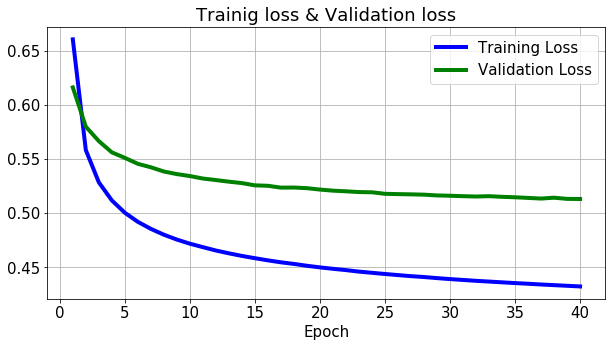

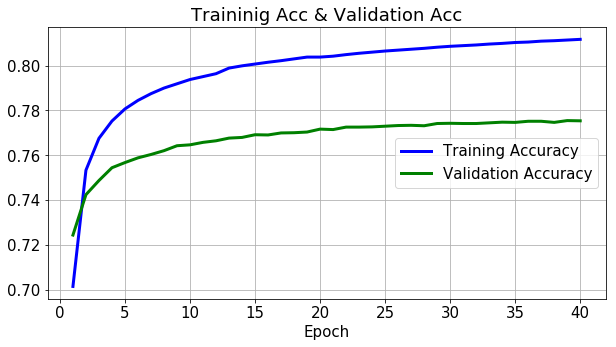

In [0]:
with open('Train_Loss', 'rb') as f:
    Loss = pickle.load(f)
with open('Val_Acc', 'rb') as f:
    Val_Acc= pickle.load(f)
with open('Train_Acc', 'rb') as f:
    Train_Acc = pickle.load(f)
with open('Val_Loss', 'rb') as f:
    Val_Loss = pickle.load(f)
    
epochs=40
epochs_plot = [i+1 for i in range (epochs)]
    
plt.figure(1, figsize=(10,5))
plt.grid()
font = {'size'   : 15}
plt.rc('font', **font)
plt.title('Trainig loss & Validation loss')
plt.xlabel('Epoch')
plt.plot(epochs_plot, Loss, linewidth=4, color='b', label='Training Loss')
plt.plot(epochs_plot, Val_Loss, linewidth=4, color='g', label='Validation Loss')
plt.legend(loc='upper right')

plt.figure(2, figsize=(10,5))
plt.grid()
font = {'size'   : 15}
plt.rc('font', **font)
plt.title('Traininig Acc & Validation Acc')
plt.xlabel('Epoch')
plt.plot(epochs_plot, Train_Acc, linewidth=3, color='b', label='Training Accuracy')
plt.plot(epochs_plot, Val_Acc, linewidth=3, color='g', label='Validation Accuracy')
plt.legend(loc='right')


# Test de los modelos y cálculo del accuracy 

Como se dijo previamente, lo que realmente es relevante es la clasificación de muestras. Por lo que se utilizará el modelo entrenado para evaluar cómo categoriza al test set de 1376 audios en cuestión. Debido a las variables elegidas, para cada audio resultan 666 ventanas a clasificar. Entonces, para cada audio, dependiendo cual sea el idioma con más ventanas clasificadas como tal, será determinado el lenguaje al que corresponda.



Clasificaciones erróneas: 24
Alemán (0): 36.186186186186184%
Inglés (1): 26.126126126126124%
Español (2): 37.687687687687685%
Idioma original: 0


Clasificaciones erróneas: 73
Alemán (0): 34.38438438438439%
Inglés (1): 17.417417417417415%
Español (2): 48.1981981981982%
Idioma original: 0


Clasificaciones erróneas: 343
Alemán (0): 42.04204204204204%
Inglés (1): 14.714714714714713%
Español (2): 43.24324324324324%
Idioma original: 0


Clasificaciones erróneas: 407
Alemán (0): 46.546546546546544%
Inglés (1): 41.591591591591595%
Español (2): 11.861861861861863%
Idioma original: 1


Clasificaciones erróneas: 501
Alemán (0): 37.08708708708709%
Inglés (1): 35.43543543543544%
Español (2): 27.47747747747748%
Idioma original: 1


Clasificaciones erróneas: 568
Alemán (0): 39.03903903903904%
Inglés (1): 31.83183183183183%
Español (2): 29.129129129129126%
Idioma original: 1


Clasificaciones erróneas: 747
Alemán (0): 42.34234234234234%
Inglés (1): 32.432432432432435%
Español (2): 25.2252252252252

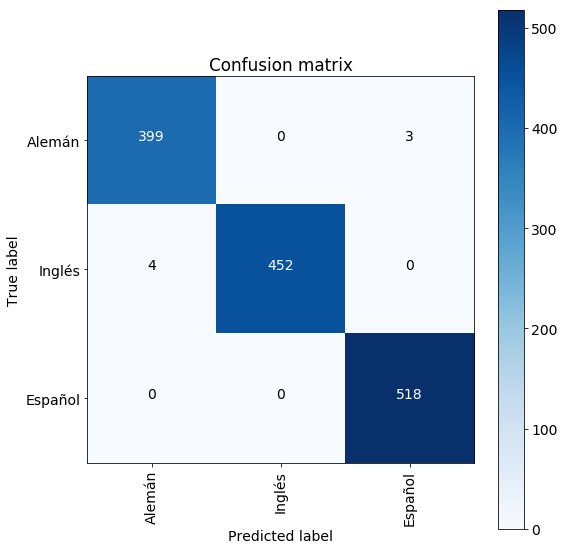




Accuracy: 99.49127906976744%.
 Se han clasificado 1369 muestras correctamente sobre un total de 1376


In [0]:
predicted_languages = list()
n=0
a= 666
for i in range(len(test_features)//a):
    
    features = test_features[n: n+a]
    predictions = model.predict(features)
    pred_language = np.argmax(predictions, axis=1)
    

    german = (pred_language==0).sum()/len(pred_language)*100
    english = (pred_language==1).sum()/len(pred_language)*100
    spanish = (pred_language==2).sum()/len(pred_language)*100
    
    if i==24 or i==73 or i==343 or i==407 or i==501 or i==568 or i==747:
        print('\n\nClasificaciones erróneas: {}'.format(i))
        print('Alemán (0): {}%'.format(german))
        print('Inglés (1): {}%'.format(english))
        print('Español (2): {}%'.format(spanish))
        print('Idioma original: {}'.format(test_languages[i]))

    if german>=english and german>=spanish:
        predicted_languages.append(0)
    elif english>german and english>spanish:
        predicted_languages.append(1)
    elif spanish>=english and spanish>german:
        predicted_languages.append(2)
    n=n+a

print('\n_____________________________________________________\nMuestras erroneas: {}'.format(errors))
   
confusion_mtx = confusion_matrix(test_languages, predicted_languages)
plot_confusion_matrix( cm = (confusion_mtx), normalize= False, target_names = ['Alemán', 'Inglés', 'Español'] )
#plt.figure(figsize=(10,7))
#sns.heatmap(confusion_mtx, annot=True, fmt="d");

errors = list()
for i in range(len(predicted_languages)):
    if predicted_languages[i]!=test_languages[i]:
        errors.append(i)
        
print('\n\n\nAccuracy: {}%.\n Se han clasificado {} muestras correctamente sobre un total de {}' .format( ((len(predicted_languages)-len(errors))*100/len(predicted_languages)), len(predicted_languages)-len(errors), len(predicted_languages)))

### Función usada para graficar

In [0]:
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8,8 ))
    font = {'size'   : 14}
    plt.rc('font', **font)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


#### Finalmente el Accuracy obtenido en la clasificación de las muestras fue de  **99.5%**

# Anexo: Testeo del modelo con muestras propias

## Español

In [0]:
duration = 10  # seconds
myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=1)

In [0]:
with open('ejemplo.flac', 'rb') as f:
    my_recording_es = pickle.load(f)

sd.play(my_recording_es, fs)
features_esp, _ = preprocess([my_recording_es], [2], n_past=7)
predictions = model.predict(features_esp)
pred_lang = np.argmax(predictions,axis = 1)
german=(pred_lang==0).sum()/len(pred_lang)*100
english=(pred_lang==1).sum()/len(pred_lang)*100
spanish=(pred_lang==2).sum()/len(pred_lang)*100

print('Aleman: {}%'.format(german))
print('Ingles: {}%'.format(english))
print('Español: {}%'.format(spanish))

Aleman: 8.224674022066198%
Ingles: 21.965897693079235%
Español: 69.80942828485456%


## Inglés

In [0]:
my_recording_en, fs = sf.read('dataset2/test/test_en.flac', dtype='float32')
sd.play(my_recording_en, fs)

In [0]:
sd.play(my_recording_en, fs)
features, _ = preprocess([my_recording_en], [1], n_past=7)
predictions = model.predict(features)
pred_lang = np.argmax(predictions,axis = 1)
german=(pred_lang==0).sum()/len(pred_lang)*100
english=(pred_lang==1).sum()/len(pred_lang)*100
spanish=(pred_lang==2).sum()/len(pred_lang)*100

print('Aleman: {}%'.format(german))
print('Ingles: {}%'.format(english))
print('Español: {}%'.format(spanish))

Aleman: 21.564694082246742%
Ingles: 54.36308926780341%
Español: 24.072216649949848%


## Alemán

In [0]:
my_recording_de, fs = sf.read('dataset2/test/test_de_2.flac', dtype='float32')
sd.play(my_recording_de, fs)

In [0]:
features, _ = preprocess([my_recording_de], [1], n_past=7)
predictions = model.predict(features)
pred_lang = np.argmax(predictions,axis = 1)

german=(pred_lang==0).sum()/len(pred_lang)*100
english=(pred_lang==1).sum()/len(pred_lang)*100
spanish=(pred_lang==2).sum()/len(pred_lang)*100

print('Aleman: {}%'.format(german))
print('Ingles: {}%'.format(english))
print('Español: {}%'.format(spanish))

Aleman: 42.226680040120364%
Ingles: 39.317953861584755%
Español: 18.455366098294885%


# MODELO CON REDES CONVOLUCIONALES: CNN



In [0]:
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D
from keras.utils import to_categorical


def get_model():
    model_cnn = Sequential()
    model_cnn.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(13, 8, 1)))
    model_cnn.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model_cnn.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(64, activation='relu'))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Dense(3, activation='softmax'))
    model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    model_cnn.summary()
    return model_cnn

In [5]:
model_cnn = get_model();

W0628 01:28:13.838608 139690106005376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 01:28:13.876758 139690106005376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 01:28:13.885561 139690106005376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 01:28:13.940310 139690106005376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0628 01:28:13.943974 139690106005376 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 7, 32)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 6, 48)         6192      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 5, 120)        23160     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 2, 120)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 2, 120)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               153728    
__________

In [7]:
checkpoint = ModelCheckpoint('MODEL_CNN.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model_cnn.fit(train_features.reshape(train_features.shape[0],13, 8,1), train_labels, batch_size=512, epochs=20, verbose=1, validation_data=(((test_features).reshape(test_features.shape[0], 13, 8, 1)), test_labels), callbacks=callbacks_list)

W0628 02:26:28.231995 139690106005376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4584744 samples, validate on 916416 samples
Epoch 1/20
4584744/4584744 [==============================] - 87s 19us/step - loss: 0.8545 - acc: 0.5911 - val_loss: 0.7531 - val_acc: 0.6557

Epoch 00001: val_acc improved from -inf to 0.65568, saving model to MODEL_CNN.h5
Epoch 2/20
4584744/4584744 [==============================] - 77s 17us/step - loss: 0.7612 - acc: 0.6497 - val_loss: 0.7089 - val_acc: 0.6765

Epoch 00002: val_acc improved from 0.65568 to 0.67653, saving model to MODEL_CNN.h5
Epoch 3/20
4584744/4584744 [==============================] - 78s 17us/step - loss: 0.7325 - acc: 0.6650 - val_loss: 0.6891 - val_acc: 0.6867

Epoch 00003: val_acc improved from 0.67653 to 0.68667, saving model to MODEL_CNN.h5
Epoch 4/20
4584744/4584744 [==============================] - 78s 17us/step - loss: 0.7169 - acc: 0.6732 - val_loss: 0.6727 - val_acc: 0.6959

Epoch 00004: val_acc improved from 0.68667 to 0.69591, saving model to MODEL_CNN.h5
Epoch 5/20
4584744/4584744 [==============

# ANALISIS DEL MODELO CON CNN

In [0]:
with open("/content/drive/My Drive/Colab Notebooks/TP FINAL REDES NEURONALES/CNN_train_acc (1)", 'rb') as f:
    CNN_train_acc = pickle.load(f)

with open("/content/drive/My Drive/Colab Notebooks/TP FINAL REDES NEURONALES/CNN_train_loss", 'rb') as f:
    CNN_train_loss = pickle.load(f)

with open("/content/drive/My Drive/Colab Notebooks/TP FINAL REDES NEURONALES/CNN_val_loss", 'rb') as f:
    CNN_val_loss = pickle.load(f)
    
with open("/content/drive/My Drive/Colab Notebooks/TP FINAL REDES NEURONALES/CNN_val_acc", 'rb') as f:
    CNN_val_acc = pickle.load(f)

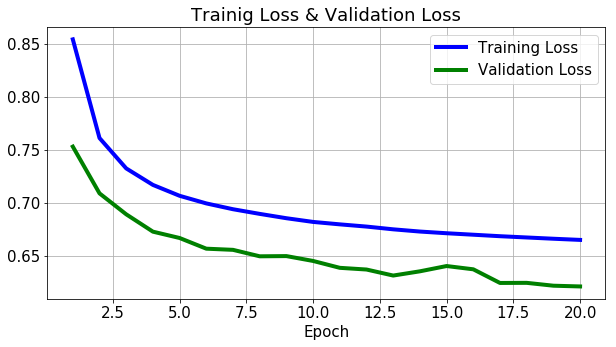

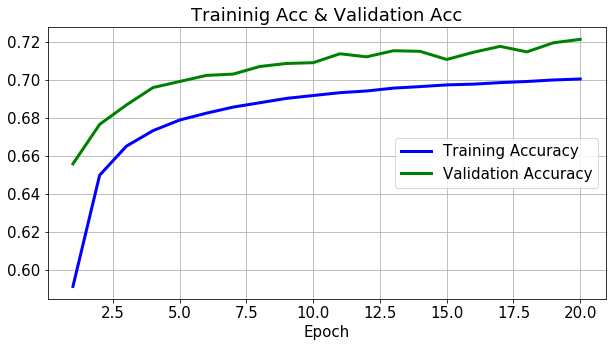

In [18]:
epochs=20
epochs_plot = [i+1 for i in range (epochs)]
    
plt.figure(1, figsize=(10,5))
plt.grid()
font = {'size'   : 15}
plt.rc('font', **font)
plt.title('Trainig Loss & Validation Loss')
plt.xlabel('Epoch')
plt.plot(epochs_plot, CNN_train_loss, linewidth=4, color='b', label='Training Loss')
plt.plot(epochs_plot, CNN_val_loss, linewidth=4, color='g', label='Validation Loss')
plt.legend(loc='upper right')

plt.figure(2, figsize=(10,5))
plt.grid()
font = {'size'   : 15}
plt.rc('font', **font)
plt.title('Traininig Acc & Validation Acc')
plt.xlabel('Epoch')
plt.plot(epochs_plot, CNN_train_acc, linewidth=3, color='b', label='Training Accuracy')
plt.plot(epochs_plot, CNN_val_acc, linewidth=3, color='g', label='Validation Accuracy')
plt.legend(loc='right')

In [0]:
 import pickle
with open("/content/drive/My Drive/Colab Notebooks/TP FINAL REDES NEURONALES/train_features", 'rb') as f:
    train_features = pickle.load(f)

with open("/content/drive/My Drive/Colab Notebooks/TP FINAL REDES NEURONALES/train_labels", 'rb') as f:
    train_labels = pickle.load(f)

with open("/content/drive/My Drive/Colab Notebooks/TP FINAL REDES NEURONALES/test_features", 'rb') as f:
    test_features = pickle.load(f)
    
with open("/content/drive/My Drive/Colab Notebooks/TP FINAL REDES NEURONALES/test_labels", 'rb') as f:
    test_labels = pickle.load(f)

In [1]:
# Ejecuta esta celda para activar tu cuenta de Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


1376 1376


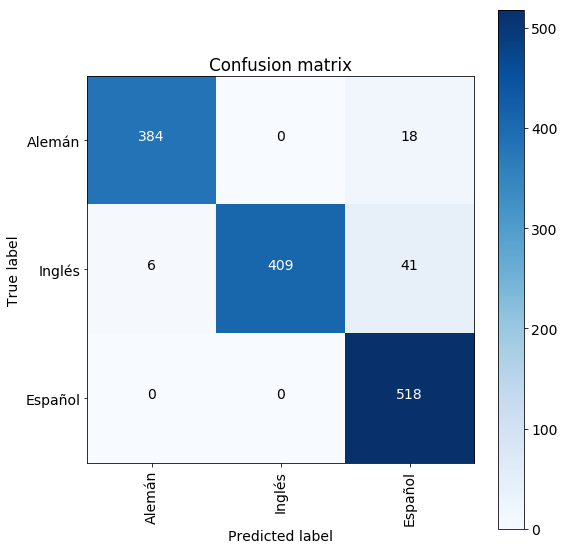




Accuracy: 95.27616279069767%.
 Se han clasificado 1311 muestras correctamente sobre un total de 1376


In [47]:
predicted_languages = list()
n=0
a= 666
var=0

for i in range(len(test_features)//a):
    
    features = test_features[n: n+a]
    predictions = model_cnn.predict(features.reshape(features.shape[0],13, 8,1))
    pred_language = np.argmax(predictions, axis=1)
    
      
    german = (pred_language==0).sum()/len(pred_language)*100
    english = (pred_language==1).sum()/len(pred_language)*100
    spanish = (pred_language==2).sum()/len(pred_language)*100
    
    if german>=english and german>=spanish:
        predicted_languages.append(0)
    elif english>german and english>spanish:
        predicted_languages.append(1)
    elif spanish>=english and spanish>german:
        predicted_languages.append(2)
    n=n+a
    
  
print(len(test_languages), len(predicted_languages))  
confusion_mtx = confusion_matrix(test_languages, predicted_languages)
plot_confusion_matrix( cm = (confusion_mtx), normalize= False, target_names = ['Alemán', 'Inglés', 'Español'] )
#plt.figure(figsize=(10,7))
#sns.heatmap(confusion_mtx, annot=True, fmt="d");

errors = list()
for i in range(len(predicted_languages)):
    if predicted_languages[i]!=test_languages[i]:
        errors.append(i)
        
print('\n\n\nAccuracy: {}%.\n Se han clasificado {} muestras correctamente sobre un total de {}' .format( ((len(predicted_languages)-len(errors))*100/len(predicted_languages)), len(predicted_languages)-len(errors), len(predicted_languages)))

In [0]:
ceros= [0 for i in range (402)]
unos= [1 for i in range (456)]
dos= [2 for i in range (518)]
test_languages=ceros+unos+dos